# MolMIM Inferencing for Generative Chemistry and Downstream Prediction

Note: This notebook was tested on a single A100 GPU using BioNeMo Framework v1.6.

## Demo Objectives

1. **MolMIM inferencing and integration with RDKit**
    * Objective: Generate hidden state representations and embeddings from SMILES strings
2. **Molecular generation**
    * Objective: Explore the chemical space by generating new molecules based on a seed SMILES string
3. **Downstream prediction using MolMIM embeddings**
    * Objective: Generate an ESOL water solubility prediction model from MolMIM embeddings

## Setup

Please ensure that you have read through the Getting Started section, can run the BioNeMo Framework docker container, and have configured the NGC Command Line Interface (CLI).


### Home Directory

Set the home directory as follows:

In [6]:
import os
bionemo_home = "/workspace/bionemo"
os.environ['BIONEMO_HOME'] = bionemo_home
os.chdir(bionemo_home)

### Import Required Libraries

In [7]:
# RDKit for handling/manipulating chemical data
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

from bionemo.utils.hydra import load_model_config
from bionemo.model.molecule.molmim.infer import MolMIMInference

[NeMo I 2024-07-26 01:46:11 megatron_hiddens:110] Registered hidden transform sampled_var_cond_gaussian at bionemo.model.core.hiddens_support.SampledVarGaussianHiddenTransform
[NeMo I 2024-07-26 01:46:11 megatron_hiddens:110] Registered hidden transform interp_var_cond_gaussian at bionemo.model.core.hiddens_support.InterpVarGaussianHiddenTransform


### Download Model Checkpoints

Now, download the pre-trained MolMIM model checkpoints:

In [8]:
!python download_artifacts.py --model_dir ${BIONEMO_HOME}/models --models molmim_70m_24_3

Running command: ngc --version

NGC CLI 3.44.0

Done.
Running command: mkdir -p /workspace/bionemo/models && ngc registry model download-version nvidia/clara/molmim:1.3 --dest /workspace/bionemo/models && mv /workspace/bionemo/models/molmim_v1.3/* /workspace/bionemo/models/ && rm -d /workspace/bionemo/models/molmim_v1.3


Done.
Running command: mkdir -p /workspace/bionemo/models/molecule/molmim && ln -sf ../../molmim_70m_24_3.nemo /workspace/bionemo/models/molecule/molmim/molmim_70m_24_3.nemo


Done.


## MolMIM Inference Functions

### Load Configurations

Here, we load pre-trained model checkpoints and point the YAML configuration file to the desired checkpoints path.

In [ ]:
# Load pre-trained model checkpoints
checkpoint_path = f"{bionemo_home}/models/molecule/molmim/molmim_70m_24_3.nemo"

# Load starting config for MolMIM inference
cfg = load_model_config(config_name="molmim_infer.yaml", config_path=f"{bionemo_home}/examples/tests/conf/")

# Point YAML configuration file to the location of the desired checkpoints
cfg.model.downstream_task.restore_from_path = checkpoint_path

# Create model object based on desired configuration
model = MolMIMInference(cfg, interactive=True)

### SMILES Examples with RDKit

Here, as an example, we will take the SMILES strings for two widely used antimalarial drugs, Mefloquine and Hydroxychloroquine, and use RDKit to display the molecues.

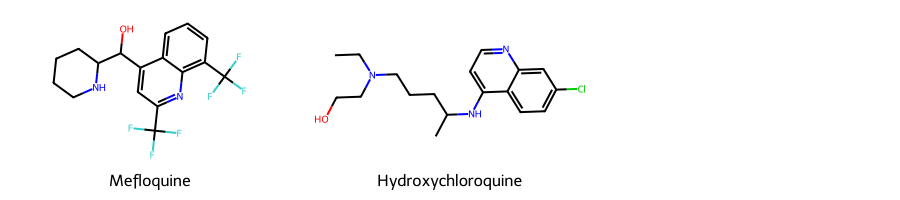

In [11]:
# Two SMILES strings
smis = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# RDKit's MolFromSmiles() function draws out the 2D molecule from the SMILES string
m1 = Chem.MolFromSmiles(smis[0])
m2 = Chem.MolFromSmiles(smis[1])
Draw.MolsToGridImage((m1,m2), legends=["Mefloquine","Hydroxychloroquine"], subImgSize=(300,200))

### From SMILES to Hidden State

We now run inference with MolMIM to find the hidden states of our starting molecules.

![molmim-hidden-state](../images/molmim-hidden-state.png)

In [18]:
# obtaining the hidden state representations for input SMILES
hidden_states, pad_masks = model.seq_to_hiddens(smis)
hidden_states.shape, pad_masks.shape

(torch.Size([2, 1, 512]), torch.Size([2, 1]))

### From SMILES to Embedding

We can also obtain their embeddings.

In [19]:
embedding = model.seq_to_embeddings(smis)
embedding.shape

torch.Size([2, 512])

### Hidden State to SMILES

Let's see if the decoder turns the hidden state into the same SMILES strings, or similar.

[NeMo I 2024-07-23 22:29:42 megatron_lm_encoder_decoder_model:1195] Decoding using the greedy-search method...
['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCC1', 'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12']


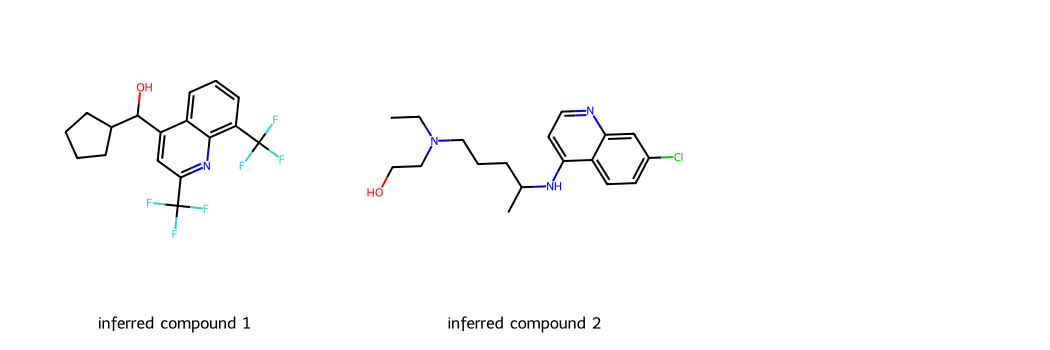

In [20]:
# Obtaining SMILES chemical representation from a hidden state using the hidden_to_seqs function 
inferred_smis = model.hiddens_to_seq(hidden_states, pad_masks)

# Examine the inferred SMILES
print(inferred_smis)

inf_1 = Chem.MolFromSmiles(inferred_smis[0])
inf_2 = Chem.MolFromSmiles(inferred_smis[1])

Draw.MolsToGridImage((inf_1,inf_2),legends=["inferred compound 1","inferred compound 2"], subImgSize=(350,350))

Let's check if they are the same compounds:

In [21]:
smis[0]==inferred_smis[0]
# DOCUMENTATION: Claims this one is the same, but it is not.

False

In [22]:
smis[1]==inferred_smis[1]

True

The second compound is the same. The first one is similar, but not the same.

## Molecular Generation and Chemical Space Exploration

In [23]:
# DOCUMENTATION: Need to update the diagrams. They show embedding matrics (of MegaMolBART) but its actually embedding vectors in MolMIM.

We now generate molecules by taking the seed molecules as input. There are multiple sampling methods available:
* greedy-perturbate
* topkp-perturbate
* beam-search-perturbate
* beam-search-single-sample
* beam-search-perturbate-sample

In [24]:
# DOCUMENTATION: WHERE WAS TORCH NEEDED HERE?
# DOCUMENTATION: Need to specify the acceptable kwargs for each sampling method

# Function to generate new SMILES strings from the model
def chem_sample(smis):
    # Note that sample() method is defined in BaseEncoderDecoderInference
        # MolMIMInference <-- MolInference <-- BaseEncoderDecoderInference
        # sample() takes in: num_samples (1), return_embedding (False), sampling_method (None), hiddens_to_seq_kwargs ({}), scaled_radius (1.0), kwargs

    # PART 1: SAMPLING
    # Set Sampling Arguments
    num_samples = 10
    scaled_radius = 0.7
    sampling_method="beam-search-perturbate" # Options: greedy-perturbate, topkp-perturbate, beam-search-perturbate, beam-search-single-sample, beam-search-perturbate-sample
    sampler_kwargs = {
        "beam_size": 3,
        "keep_only_best_tokens": True,
        "return_scores": False
    }    
    
    # Do sampling
    population_samples = model.sample(seqs=smis, num_samples=num_samples, scaled_radius=scaled_radius, sampling_method="beam-search-perturbate", **sampler_kwargs)

    # PART 2: FILTER RESULTS
    uniq_canonical_smiles = []
    # Loop (repeat) for each seed molecule
    for smis_samples, original in zip(population_samples, smis):
        # Very simple step: Take the generated molecules, and:
        # 1) Remove duplicates
        # 2) Remove the original if it was produced in the set of generated molecules
        smis_samples = set(smis_samples) - set([original])

        # Collect subset of valid molecules from the generated molecules
        valid_molecules = []
        for smis in smis_samples:
            mol = Chem.MolFromSmiles(smis) # invalid mol's will get type NoneType and be filtered out
            if mol:
                valid_molecules.append(Chem.MolToSmiles(mol,True))
        uniq_canonical_smiles.append(valid_molecules)
    return uniq_canonical_smiles # List (dim = # of seed molecules) of lists (dim = # of valid generated molecules per seed)

In [25]:
# Redefining the same smis
smis_lst = ['OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1',     
        'CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12'] 

# Using the chem_sample function to generate new, valid molecules from input smis
gen_smis_lst = chem_sample(smis_lst)

[NeMo I 2024-07-23 22:29:45 megatron_lm_encoder_decoder_model:1192] Decoding using the beam search method with beam size=3...


In [26]:
# Print Results
for ori_smis, gen_smis in zip(smis_lst, gen_smis_lst):
        print(f"Original SMILES: {ori_smis}")
        print(f"Generated {len(gen_smis)} unique/valid SMILES: {gen_smis}")
        print("\n")

Original SMILES: OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCCN1
Generated 10 unique/valid SMILES: ['OCc1ncc(C(F)(F)F)nc1N(CC(F)(F)F)C1CC1', 'OC(c1cc(C(F)(F)F)ncc1Cl)(C(F)F)N1CCCCCC1', 'OC(c1csc(Br)c1)c1cc(C(F)(F)F)ncn1', 'O=C(O)C(F)(F)CCCNS(=O)(=O)c1ccccc1', 'OCc1ncc(C(F)(F)F)nc1N(C[C@H]1CCCO1)CC(F)(F)F', 'OC[C@@H]1C[C@H](NC(F)(F)F)C12CCC2', 'OC(c1c(NC[C@H]2CCOC2)nc2ccccn12)(C1CC1)C1CC1', 'OCc1ccc(C(F)(F)F)nc1N(Cc1ccccc1)c1ccccc1', 'OC(c1cc(C(F)(F)F)nc2c(C(F)(F)F)cccc12)C1CCCC1', 'O[C@@H](c1cc(C(F)(F)F)ncn1)C(F)(F)Br']


Original SMILES: CCN(CCO)CCCC(C)Nc1ccnc2cc(Cl)ccc12
Generated 9 unique/valid SMILES: ['CCN(CCO)CCCC(=O)Nc1cnc2cc(Cl)ccc2n1', 'CCN(CCO)CCCC(=O)N1CCSc2cc(Cl)ccc21', 'CCN(CCO)CCCC(=O)N1CCNc2cc(Cl)ccc21', 'CCN(CCO)CCCCN(C)c1ccnc2cc(Cl)ccc12', 'CCN(CCO)CCC[C@@H](C)Nc1ccnc2c(Cl)cccc12', 'CCN(CC(=O)NC)C[C@H](N)c1nc2cc(Cl)ccc2s1', 'CCN(CCO)CCNC(=O)c1ccnc2cc(Cl)ccc12', 'CCN(CCO)CCCC(=O)N[C@H](C)c1cc(Cl)cc2c1OCC2', 'CCN(CCO)CCCC(=O)Nc1cnc2cc(Cl)ccn12']




## Downstream Prediction Model (Using Learned Embeddings from Pre-Trained Model)

## (e.g. ESOL Water Solubility Prediction)

In [33]:
# DOCUMENTATION: Said dataset is not available in the container, must be downloaded online
!wget -O delaney-processed2.csv https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv

--2024-07-23 22:33:11--  https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv
Resolving deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)... 52.219.216.50, 3.5.163.189, 3.5.163.174, ...
Connecting to deepchemdata.s3-us-west-1.amazonaws.com (deepchemdata.s3-us-west-1.amazonaws.com)|52.219.216.50|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/csv]
Saving to: ‘delaney-processed2.csv’

delaney-processed2. 100%[===================>]  94.43K  --.-KB/s    in 0.08s   

2024-07-23 22:33:12 (1.19 MB/s) - ‘delaney-processed2.csv’ saved [96699/96699]



Visit https://moleculenet.org/datasets-1 and download the ESOL dataset (water solubility for common organic small molecules).

### Data Preprocessing

In [29]:
ex_data_file = './kushah_test_workspace/delaney-processed.csv'
ex_df = pd.read_csv(ex_data_file)

In [30]:
# Checking the dimensions of the dataframe and the first few rows
print(ex_df.shape)
ex_df.head()

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


### Obtain embeddings using seqs_to_embedding

In [31]:
# DOCUMENTATION: cudf dependency removed
# DOCUMENTATION: With the new dataset, the indexes of smiles and x_val are no longer correct (2/3 --> 9/1) so updated to column names directly

ex_emb_df = pd.DataFrame()
smis = ex_df.loc[:, 'smiles']
x_val = ex_df.loc[:, 'ESOL predicted log solubility in mols per litre']
embedding = model.seq_to_embeddings(smis.tolist())
ex_emb_df = pd.concat([ex_emb_df,
                         pd.DataFrame({"SMILES": smis,
                                         "EMBEDDINGS": embedding.tolist(),
                                         "Y": x_val})])  # The ESOL value is captured in the 'Y' column

ex_emb_df

,SMILES,EMBEDDINGS,Y
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0.4140458106994629, 0.4627712070941925, 0.582...",-0.974
1,Cc1occc1C(=O)Nc2ccccc2,"[-0.1994795948266983, -0.0786716639995575, -0....",-2.885
2,CC(C)=CCCC(C)=CC(=O),"[-0.4748702049255371, -0.8526585102081299, -0....",-2.579
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[-0.2653975486755371, -0.1304905116558075, 0.1...",-6.618
4,c1ccsc1,"[-0.5700850486755371, -0.8756077289581299, 0.1...",-2.232
...,...,...,...
1123,FC(F)(F)C(Cl)Br,"[0.1985916942358017, 0.2149684727191925, -0.07...",-2.608
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,"[-0.0940108448266983, 0.9334743022918701, -0.3...",-0.908
1125,CCSCCSP(=S)(OC)OC,"[0.6227860450744629, 0.4312770664691925, 0.255...",-3.323
1126,CCC(C)C,"[0.2170243114233017, 0.1397731602191925, -0.07...",-2.245


### Obtain Morgan Fingerprints Using RDKit Functionalities

In [32]:
%%time
# Here, we will define a function to return Morgan Fingerprints for a list of input SMILES
def get_fp_arr(df_smi):
    fp_array = []
    for smi in df_smi:
        m = Chem.MolFromSmiles(smi)                               # Converting SMILES to RD-Kit's MOL format
        fp =  AllChem.GetMorganFingerprintAsBitVect(m, 3, 1024)   # Obtain Morgan Fingerprints as a Bit-vector
        fp = np.fromstring(fp.ToBitString(), 'u1') - ord('0')     # Converting Bit-vector to string type
        fp_array.append(fp)
    fp_array = np.asarray(fp_array)
    return fp_array.tolist()

# Passing the SMILES list to the get_fp_arr function, and saving the returned list of Morgan Fingerprints as a DataFrame column named 'FINGERPRINTS'
ex_emb_df['FINGERPRINT'] = get_fp_arr(ex_emb_df['SMILES'].tolist())

# Let's take a look at the DataFrame after Morgan_Fingerprint calculation
ex_emb_df

[NeMo W 2024-07-23 22:29:51 nemo_logging:349] <timed exec>:7: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
    


CPU times: user 182 ms, sys: 5.45 ms, total: 187 ms
Wall time: 186 ms


,SMILES,EMBEDDINGS,Y,FINGERPRINT
0,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...,"[0.4140458106994629, 0.4627712070941925, 0.582...",-0.974,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,Cc1occc1C(=O)Nc2ccccc2,"[-0.1994795948266983, -0.0786716639995575, -0....",-2.885,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,CC(C)=CCCC(C)=CC(=O),"[-0.4748702049255371, -0.8526585102081299, -0....",-2.579,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43,"[-0.2653975486755371, -0.1304905116558075, 0.1...",-6.618,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,c1ccsc1,"[-0.5700850486755371, -0.8756077289581299, 0.1...",-2.232,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...
1123,FC(F)(F)C(Cl)Br,"[0.1985916942358017, 0.2149684727191925, -0.07...",-2.608,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1124,CNC(=O)ON=C(SC)C(=O)N(C)C,"[-0.0940108448266983, 0.9334743022918701, -0.3...",-0.908,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
1125,CCSCCSP(=S)(OC)OC,"[0.6227860450744629, 0.4312770664691925, 0.255...",-3.323,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1126,CCC(C)C,"[0.2170243114233017, 0.1397731602191925, -0.07...",-2.245,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## ML Model Generation

### SVR Model: Predicting ESOL Using Morgan Fingerprints

In [113]:
# Splitting the input dataset into Training (70%) and Test sets(30%)
tempX = np.asarray(ex_emb_df['FINGERPRINT'].tolist(), dtype=np.float32)
tempY = np.asarray(ex_emb_df['Y'], dtype=np.float32)
x_train, x_test_mfp, y_train, y_test_mfp  = train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_mfp = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)     # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
# cupy worked until here - but cannot convert to numpy array now - removing all rapids
reg_mfp.fit(x_train, y_train)
# SVR()

pred_mfp = reg_mfp.predict(x_test_mfp)

# Performance measures of SVR model - Mean Squared Error and R-squared values
mfp_SVR_MSE = mean_squared_error(y_test_mfp, pred_mfp)
mfp_SVR_R2 = r2_score(y_test_mfp, pred_mfp)

print("Fingerprint_SVR_MSE: ", mfp_SVR_MSE)
print("Fingerprint_SVR_r2: ", mfp_SVR_R2)

Fingerprint_SVR_MSE:  0.7641448155400202
Fingerprint_SVR_r2:  0.7368847287139371


### SVR Model: Predicting ESOL Using MolMIM Embeddings

In [114]:
### Using BioNeMo-MolMIM Embeddings for developing a SVR model ###

# Splitting dataset into training and testing sets
tempX = np.asarray(ex_emb_df['EMBEDDINGS'].tolist(), dtype=np.float32)
tempY = np.asarray(ex_emb_df['Y'], dtype=np.float32)
x_train, x_test_emb, y_train, y_test_emb  = train_test_split(tempX, tempY, train_size=0.7, random_state=1993)

# Defining Support vector regression model parameters 
reg_emb = SVR(kernel='rbf', gamma='scale', C=10, epsilon=0.1)    # You may change the model parameters and observe the change in the performance

# Fitting the model on the training dataset
reg_emb.fit(x_train, y_train)

# Using the fitted model for prediction of the ESOL values for the test dataset compounds
pred_emb = reg_emb.predict(x_test_emb)

# Performance measures of SVR model
emb_SVR_MSE = mean_squared_error(y_test_emb, pred_emb)
emb_SVR_R2 = r2_score(y_test_emb, pred_emb)

print("Embeddings_SVR_MSE: ", emb_SVR_MSE)
print("Embeddings_SVR_r2: ", emb_SVR_R2)

Embeddings_SVR_MSE:  0.8740699179366671
Embeddings_SVR_r2:  0.6990346084879662


### Results

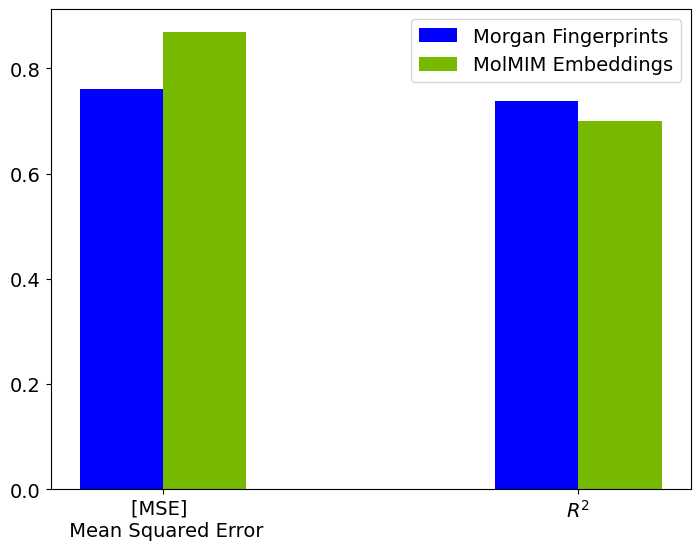

In [106]:
plt.rcParams.update({'font.size': 14})
data = [[mfp_SVR_MSE, mfp_SVR_R2], [emb_SVR_MSE, emb_SVR_R2]]
X = np.arange(2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, data[0], color = 'b', width = 0.20)
ax.bar(X + 0.20, data[1], color = '#76b900', width = 0.20)
ax.set_xticks([0.1, 1.1])
ax.set_xticklabels(['[MSE] \n Mean Squared Error', '$R^2$'])
ax.legend(['Morgan Fingerprints', 'MolMIM Embeddings'],loc='best')